In [1]:
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_cad = pd.read_csv("./processed_data/cadastro.csv")
df_medicoes = pd.read_csv("./processed_data/medicoes_texto_corrigido.csv")
df_qualificacao = pd.read_csv("./processed_data/qualificacao.csv")
df_risco = pd.read_csv("./processed_data/risco_cluster.csv")

## Qualificação das Medições

$
S \;=\; w_{d}\,(1 - d_{\mathrm{norm}}) 
    \;+\; w_{s}\,\frac{s_{\mathrm{resp}} + s_{\mathrm{coment}} + 2}{4} 
    \;+\; w_{r}\,(1 - r)
$

d_norm -> Desvio normalizado da medição

s_resp -> sentimento da categoria da resposta

s_coment -> sentimento do Texto de comentario

r -> risco do cluster

In [3]:
map_ = {
    'positivo': 1,
    'negativo': -1,
    'neutro': 0
}
df_medicoes['categoria_sentimento_int'] = df_medicoes['resposta_categoria_sentimento'].apply(lambda x: map_.get(x, 0))

map_ = {
    'Positivo': 1,
    'Negativo': -1,
    'Neutro': 0
}
df_medicoes['texto_classificado_int'] = df_medicoes['Texto_classificado'].apply(lambda x: map_.get(x, 0))

df_medicoes['prop_risco_cluster'] = df_medicoes['prop_risco_cluster'].fillna(0)

LIMITE_MAX = np.percentile(df_medicoes['desvio'][df_medicoes['desvio'] > 0], 95)
d_clipped = np.clip(df_medicoes['desvio'], 0, LIMITE_MAX)  # LIMITE_MAX pode ser 5, 10, 20... baseado na distribuição
d_norm = d_clipped / LIMITE_MAX

# Peso do desvio. Menor porque é bem ruidoso
w1 = 0.1
# Peso do sentimento. 
w2 = 0.3
# Peso do risco geografico.
w3 = 0.6

df_medicoes['score'] = (
    w1*(1 - d_norm) +
    w2*(df_medicoes['categoria_sentimento_int'] + df_medicoes['texto_classificado_int'] + 2)/4 +
    w3*(1 - df_medicoes['prop_risco_cluster'])
)


def threshold_score(score):
    if score <= 0.1:
        return 0
    elif score <= 0.2:
        return 1
    elif score <= 0.3:
        return 2
    elif score <= 0.5:
        return 3
    elif score <= 0.8:
        return 4
    else:
        return 5

    
df_medicoes['nova_qualificacao'] = df_medicoes['score'].apply(threshold_score)

In [4]:
df_medicoes.to_csv("./processed_data/medicoes_texto_corrigido.csv", index=False)

## Qualificação das Torres

In [5]:
# Listar 2 ultimas qualificações de cada torre

df_medicoes_sorted = df_medicoes.sort_values(['Equipamento', 'Data'], ascending=[True, False])
df_latest_dates = df_medicoes_sorted.groupby('Equipamento').head(2)
df_latest_dates_grouped = df_latest_dates.groupby('Equipamento')['Data'].apply(list)
df_latest_dates_grouped

Equipamento
100001                [2018-10-19]
100002                [2018-10-19]
100003    [2022-12-01, 2021-04-19]
100004    [2024-10-11, 2023-12-07]
100005                [2018-10-19]
                    ...           
323949                [2025-02-18]
323954                [2025-02-18]
323955                [2025-02-18]
323957    [2025-02-18, 2025-02-18]
323958                [2025-02-18]
Name: Data, Length: 32021, dtype: object

In [6]:
import tqdm

data_qualificacao = []

for equip_idx, dates in tqdm.tqdm(zip(df_latest_dates_grouped.index, df_latest_dates_grouped)):

    aux_ = df_medicoes[df_medicoes['Equipamento'] == equip_idx]
    aux_ = aux_[(aux_['Data'].isin(dates)) & (aux_['Data'] > '2022-01-01')]

    if len(aux_) > 0:
        score_torre = aux_['score'].mean()
        nova_qualificacao = aux_['nova_qualificacao'].min()
    else:
        score_torre = -1
        nova_qualificacao = 9

    

    data_qualificacao.append({
        'Equipamento': equip_idx,
        'Score': score_torre,
        'Qualificacao': nova_qualificacao
    })



32021it [00:51, 617.61it/s]


In [7]:
df_nova_qualificacao = pd.DataFrame(data_qualificacao)
df_nova_qualificacao.to_csv("./processed_data/nova_qualificacao_torre.csv", index=False)


df_nova_qualificacao.head(3)

,Equipamento,Score,Qualificacao
0,100001,-1.000000,9
1,100002,-1.000000,9
2,100003,0.616929,4


In [8]:
# Merge the new qualification dataframe with the cadastral dataframe
df_merged = pd.merge(df_nova_qualificacao, df_cad, on='Equipamento', how='left')
df_merged.to_csv("./processed_data/nova_qualificacao_torre.csv", index=False)


In [9]:
df_merged[df_merged['Qualificacao'] == 9]

,Equipamento,Score,Qualificacao,Linha de Transmissão,Denominação,Classe,Código ABC,Tensão,Latitude,Longitude
0,100001,-1.0,9,LT9142,Torre 000-P,L_PORTICO,C,69,-24.108815,-49.324733
1,100002,-1.0,9,LT9142,Torre 001,L_TORRE_AUTOPORT,C,69,-24.108504,-49.324777
4,100005,-1.0,9,LT9142,Torre 004,L_TORRE_AUTOPORT,C,69,-24.106687,-49.316652
5,100006,-1.0,9,LT9142,Torre 005,L_TORRE_AUTOPORT,C,69,-24.106250,-49.315641
6,100007,-1.0,9,LT9142,Torre 006,L_TORRE_AUTOPORT,C,69,-24.105484,-49.313858
...,...,...,...,...,...,...,...,...,...,...
30965,292875,-1.0,9,LT027,Torre 037,L_TORRE_AUTOPORT,C,138,-22.190966,-48.043069
30967,292877,-1.0,9,LT027,Torre 039,L_TORRE_AUTOPORT,C,138,-22.186675,-48.038398
30988,292898,-1.0,9,LT027,Torre 060,L_TORRE_AUTOPORT,C,138,-22.140626,-47.988286
31105,293530,-1.0,9,LT4185,Torre 091A,L_TORRE_AUTOPORT,C,440,-21.593494,-51.610768


In [10]:
df_latest_dates_grouped

Equipamento
100001                [2018-10-19]
100002                [2018-10-19]
100003    [2022-12-01, 2021-04-19]
100004    [2024-10-11, 2023-12-07]
100005                [2018-10-19]
                    ...           
323949                [2025-02-18]
323954                [2025-02-18]
323955                [2025-02-18]
323957    [2025-02-18, 2025-02-18]
323958                [2025-02-18]
Name: Data, Length: 32021, dtype: object

## Saude das Linhas de Transmissão

In [11]:
avg_score = {}

for equip_idx, dates in tqdm.tqdm(zip(df_latest_dates_grouped.index, df_latest_dates_grouped)):

    aux_ = df_medicoes[df_medicoes['Equipamento'] == equip_idx]
    aux_ = aux_[(aux_['Data'].isin(dates)) & (aux_['Data'] > '2022-01-01')]
    
    if len(aux_) > 0:
        line_id = aux_['Linha de Transmissão_y'].values[0]


        if line_id not in avg_score:
            avg_score[line_id] = []

        avg_score[line_id].append(aux_['score'].mean())







32021it [00:51, 627.63it/s]


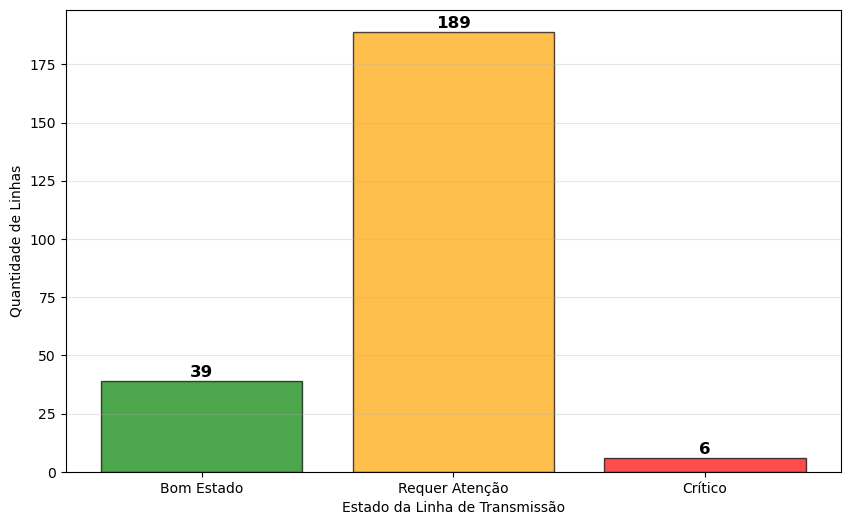

In [12]:
bom_estado = sum([(sum(v)/len(v))>0.7 for k,v in avg_score.items()])
requer_atencao = sum([(sum(v)/len(v))>0.5 and (sum(v)/len(v))<0.7 for k,v in avg_score.items()])
critico = sum([(sum(v)/len(v))<0.5 for k,v in avg_score.items()])

import matplotlib.pyplot as plt

# Create bar plot
estados = ['Bom Estado', 'Requer Atenção', 'Crítico']
valores = [bom_estado, requer_atencao, critico]

plt.figure(figsize=(10, 6))
bars = plt.bar(estados, valores, color=['green', 'orange', 'red'], alpha=0.7, edgecolor='black')

# Add value labels on top of bars
for bar, valor in zip(bars, valores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(valor), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Estado da Linha de Transmissão')
plt.ylabel('Quantidade de Linhas')
# plt.title('Distribuição do Estado de Saúde das Linhas de Transmissão')
plt.grid(True, alpha=0.3, axis='y')
# plt.show()
plt.savefig("./estado_saude_linhas.png")


In [13]:
[k for k,v in avg_score.items() if (sum(v)/len(v))<0.5]

['LT261', 'LT1226', 'LT297', 'LT6157', 'LT6199', 'LT6201']